<a href="https://colab.research.google.com/github/gonzalorodriguezrovira/TFG_SkinAnalizer/blob/main/Codigo/TFG_Analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modulos**

In [ ]:
# Carga de modulos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import sys

from google.colab import drive

# Se monta Drive para poder extraer los datos
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/MyDrive')
TFG_METADATA='/content/gdrive/MyDrive/ISIC_256x256/train.csv'

Mounted at /content/gdrive


# **Carga y analisis de datos**

In [ ]:
# Se carga el dataframe y se muestra
df_ISIC = pd.read_csv(TFG_METADATA)
df_ISIC.head(5)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,0,4,1022,767
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767


In [ ]:
# Se muestras las dimensiones de la tabla
df_ISIC.shape

(25331, 11)

In [ ]:
# Se comprueba como se informa en el dataset que la columna patient_id es siempre -1
df_ISIC['patient_id'].unique()

array([-1])

In [ ]:
# Se carga y se muestra el dataframe pandas con los ITA
df_ITA = pd.read_csv('/content/gdrive/MyDrive/df_ITA.csv')
df_ITA.head(5)

,image_name,ITA
0,ISIC_0000002,6
1,ISIC_0000006,6
2,ISIC_0000074,6
3,ISIC_0000226,1
4,ISIC_0000234,1


In [ ]:
# Se eliminan las columnas patient_id,width,height,tfrecord,target al no ser relevantes para este estudio, se muestra la dimensiones
# Se elimina la columna benign_malignant ya que solo considera los melanomas como malignos, para este estudio se consideraran mas casos malignos
df_ISIC = df_ISIC.drop(columns=["patient_id", "tfrecord", "width", "height","target","benign_malignant"], axis=1)
df_ISIC.shape

(25331, 5)

In [ ]:
# De esta manera quedarian los primeros 5 filas
df_ISIC.head(5)

,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis
0,ISIC_0000000,female,55.0,anterior torso,NV
1,ISIC_0000001,female,30.0,anterior torso,NV
2,ISIC_0000002,female,60.0,upper extremity,MEL
3,ISIC_0000003,male,30.0,upper extremity,NV
4,ISIC_0000004,male,80.0,posterior torso,MEL


In [ ]:
# Se cuentan las filas que contengan una imagen con el prefijo "downsampled"
# Son imagenes ya contenidas modificando su posicion/angulo
df_ISIC[df_ISIC['image_name'].str.contains("_downsampled")]['image_name'].count()

2074

In [ ]:
# Se eliminan y se muestra las dimensiones finales de la tabla
df_ISIC = df_ISIC[df_ISIC['image_name'].str.contains("_downsampled")==False]
df_ISIC.shape

(23257, 5)

# **Transformacion de datos**

In [ ]:
# Se agrupan las edades
ages = [0, 15, 30, 45, 60, 75, 90, 105, 120]
# Se crea una nueva columna con agrupaciones por edades
df_ISIC['age_group'] = pd.cut(df_ISIC['age_approx'], ages).astype(str).replace('nan', 'unknown')

# Se argupan los diagnosticos malignos
malignant =['MEL','BCC','SCC']
# Se crea una nueva columna con la gravedad del diagnostico
df_ISIC['benign_malignant'] = df_ISIC['diagnosis'].apply(lambda x: 'malignant' if x in malignant else 'benign')



In [ ]:
# Se combinan los dataframes de metadatos y el de tono de piel
df_ITA["ITA"] = df_ITA["ITA"].fillna("-1").astype(int).astype(str).replace('-1', None)

df_ISIC = df_ISIC.merge(df_ITA, on='image_name', how='left')

df_ISIC.dtypes

image_name                        object
sex                               object
age_approx                       float64
anatom_site_general_challenge     object
diagnosis                         object
age_group                         object
benign_malignant                  object
ITA                               object
dtype: object

In [ ]:
# Se calcula el total y el porcentaje de filas con campos desconocidos
# Al representar tan pocos y al poder dar informacion confusa serán eliminados
total_filas_unknown = (df_ISIC.isin(['unknown']).any(axis=1)).sum()
print("Total\n",total_filas_unknown)
print("Porcentaje\n",total_filas_unknown/len(df_ISIC))


Total
 277
Porcentaje
 0.011910392569978931


In [ ]:
# Se eliminan las filas que tengan algun campo con valor desconocido
df_ISIC = df_ISIC[~df_ISIC.isin(['unknown']).any(axis=1)]

In [ ]:
# Se muestra el estado final de la tabla
df_ISIC.head(5)

,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,age_group,benign_malignant,ITA
0,ISIC_0000000,female,55.0,anterior torso,NV,"(45, 60]",benign,6
1,ISIC_0000001,female,30.0,anterior torso,NV,"(15, 30]",benign,6
2,ISIC_0000002,female,60.0,upper extremity,MEL,"(45, 60]",malignant,6
3,ISIC_0000003,male,30.0,upper extremity,NV,"(15, 30]",benign,1
4,ISIC_0000004,male,80.0,posterior torso,MEL,"(75, 90]",malignant,1


# **Analisis distributivo**

In [ ]:
# Reparto de todos los diagnosticos
print("Total de casos\n")
print("Totales")
print((df_ISIC['diagnosis'].value_counts()).to_string())
print("\nPorcentajes")
print(round(df_ISIC['diagnosis'].value_counts(normalize=True) * 100,2).to_string())

Total de casos

Totales
NV      11355
MEL      4114
BCC      3317
BKL      2214
AK        864
SCC       628
VASC      249
DF        239

Porcentajes
NV      49.41
MEL     17.90
BCC     14.43
BKL      9.63
AK       3.76
SCC      2.73
VASC     1.08
DF       1.04


In [ ]:
# Reparto de casos separados
print("Total de casos\n")
print("Totales")
print((df_ISIC['benign_malignant'].value_counts()).to_string())
print("\nPorcentajes")
print(round(df_ISIC['benign_malignant'].value_counts(normalize=True) * 100,2).to_string())

Total de casos

Totales
benign       14921
malignant     8059

Porcentajes
benign       64.93
malignant    35.07


In [ ]:
# Informacion de las categorias
col_categories = ["sex", "age_group", "anatom_site_general_challenge","ITA"]
for col in col_categories:
  print('Categoria:',col)
  print("----------------------------")
  print("Casos totales\n")
  print("Numerico")
  print((df_ISIC[col].value_counts()).to_string())
  print("\nPorcentajes")
  print(round(df_ISIC[col].value_counts(normalize=True) * 100,2).to_string())
  print("\nNumerico benign_malignant")
  print(pd.crosstab(df_ISIC[col],df_ISIC["benign_malignant"]))
  print("\nPorcentajes benign_malignant")
  crosstb = round(pd.crosstab(df_ISIC[col],df_ISIC["benign_malignant"], normalize='index')*100, 2)
  print(crosstb)
  print("\n")

Categoria: sex
----------------------------
Casos totales

Numerico
male      12248
female    10732

Porcentajes
male      53.3
female    46.7

Numerico benign_malignant
benign_malignant  benign  malignant
sex                                
female              7345       3387
male                7576       4672

Porcentajes benign_malignant
benign_malignant  benign  malignant
sex                                
female             68.44      31.56
male               61.85      38.15


Categoria: age_group
----------------------------
Casos totales

Numerico
(45, 60]    6230
(30, 45]    6086
(60, 75]    5544
(75, 90]    2619
(15, 30]    2078
(0, 15]      423

Porcentajes
(45, 60]    27.11
(30, 45]    26.48
(60, 75]    24.13
(75, 90]    11.40
(15, 30]     9.04
(0, 15]      1.84

Numerico benign_malignant
benign_malignant  benign  malignant
age_group                          
(0, 15]              412         11
(15, 30]            1840        238
(30, 45]            4937       1149
(45, 6

In [ ]:
df_ISIC

,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,age_group,benign_malignant,ITA
0,ISIC_0000000,female,55.0,anterior torso,NV,"(45, 60]",benign,6
1,ISIC_0000001,female,30.0,anterior torso,NV,"(15, 30]",benign,6
2,ISIC_0000002,female,60.0,upper extremity,MEL,"(45, 60]",malignant,6
3,ISIC_0000003,male,30.0,upper extremity,NV,"(15, 30]",benign,1
4,ISIC_0000004,male,80.0,posterior torso,MEL,"(75, 90]",malignant,1
...,...,...,...,...,...,...,...,...
23252,ISIC_0073247,female,85.0,head/neck,BCC,"(75, 90]",malignant,1
23253,ISIC_0073248,male,65.0,anterior torso,BKL,"(60, 75]",benign,6
23254,ISIC_0073249,male,70.0,lower extremity,MEL,"(60, 75]",malignant,1
23255,ISIC_0073251,female,55.0,palms/soles,NV,"(45, 60]",benign,3


# **Representación grafica**

<Figure size 700x400 with 0 Axes>

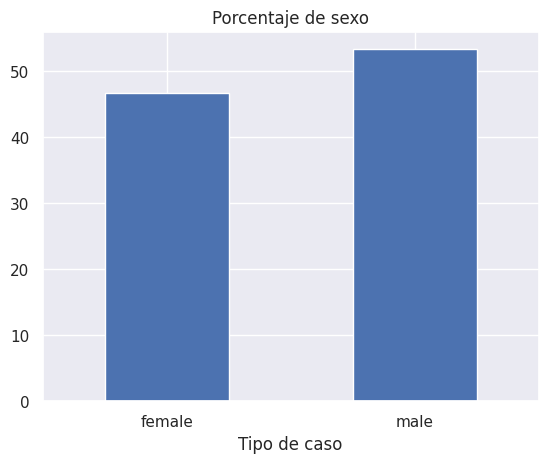

In [ ]:
# Calculo porcentajes
crosstab = pd.crosstab(df_ISIC['sex'], columns='count', normalize=True) * 100

# Se mujestran las graficas
plt.figure(figsize=(7, 4))
crosstab.plot(kind='bar', rot=0)

plt.title('Porcentaje de sexo')
plt.xlabel('Tipo de caso')
plt.ylabel('')
plt.xticks(rotation=0)
plt.legend().set_visible(False)
plt.show()

<Figure size 700x400 with 0 Axes>

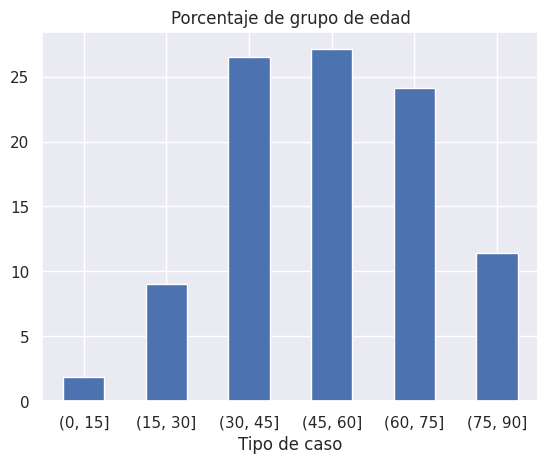

In [ ]:
# Calculo porcentajes
crosstab = pd.crosstab(df_ISIC['age_group'], columns='count', normalize=True) * 100

# Se mujestran las graficas
plt.figure(figsize=(7, 4))
crosstab.plot(kind='bar', rot=0)

plt.title('Porcentaje de grupo de edad')
plt.xlabel('Tipo de caso')
plt.ylabel('')
plt.xticks(rotation=0)
plt.legend().set_visible(False)
plt.show()

<Figure size 700x400 with 0 Axes>

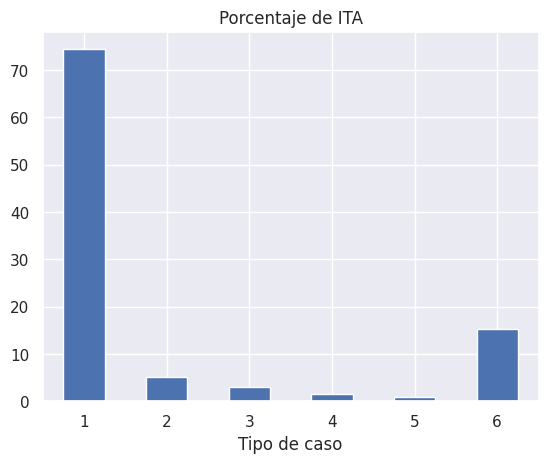

In [ ]:
# Calculo porcentajes
crosstab = pd.crosstab(df_ISIC['ITA'], columns='count', normalize=True) * 100

# Se mujestran las graficas
plt.figure(figsize=(7, 4))
crosstab.plot(kind='bar', rot=0)

plt.title('Porcentaje de ITA')
plt.xlabel('Tipo de caso')
plt.ylabel('')
plt.xticks(rotation=0)
plt.legend().set_visible(False)
plt.show()

In [ ]:
# Calculo porcentajes
crosstab = pd.crosstab(df_ISIC['benign_malignant'], columns='count', normalize=True) * 100

# Se mujestran las graficas
plt.figure(figsize=(7, 4))
crosstab.plot(kind='bar', color='indianred', rot=0)

plt.title('Porcentaje de casos benignos y malignos')
plt.xlabel('Tipo de caso')
plt.ylabel('')
plt.xticks(rotation=0)
plt.legend().set_visible(False)
plt.show()

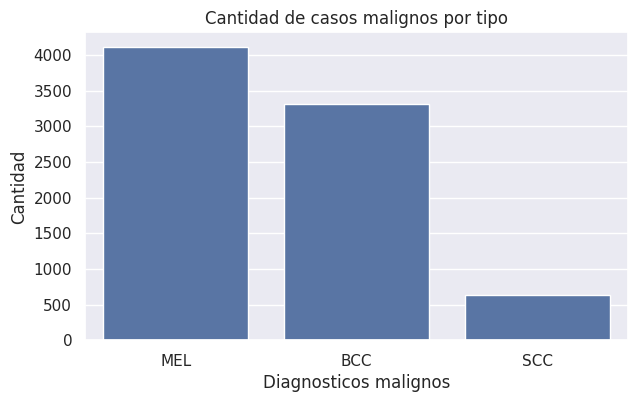

In [ ]:
df_malignant = df_ISIC[df_ISIC['benign_malignant'] == 'malignant']
order = df_malignant.groupby('diagnosis').size().sort_values(ascending=False).index

plt.figure(figsize=(7, 4))
sns.countplot(data=df_malignant, x='diagnosis', hue='benign_malignant', order=order)
plt.title('Cantidad de casos malignos por tipo')
plt.xlabel('Diagnosticos malignos')
plt.ylabel('')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)
plt.legend().set_visible(False)
plt.show()


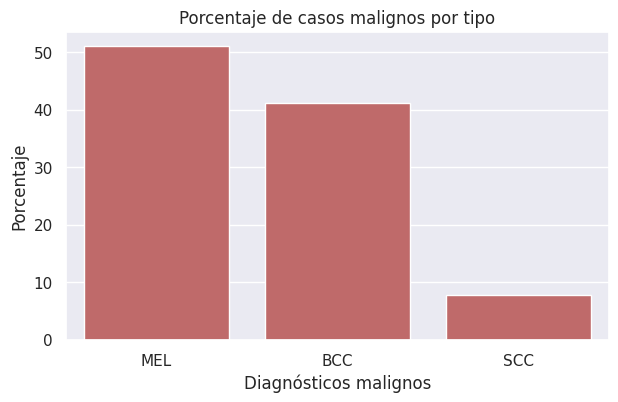

In [ ]:
# Seleccionar solo los casos malignos
df_malignant = df_ISIC[df_ISIC['benign_malignant'] == 'malignant']

# Contar la cantidad de casos malignos por tipo
malignant_counts = df_malignant['diagnosis'].value_counts()

# Calcular los porcentajes
total_malignant_cases = len(df_malignant)
malignant_percentages = (malignant_counts / total_malignant_cases) * 100

plt.figure(figsize=(7, 4))
# Utilizar un gráfico de barras para mostrar la cantidad de casos malignos por tipo
sns.barplot(x=malignant_percentages.index, y=malignant_percentages.values,color="indianred")
plt.title('Porcentaje de casos malignos por tipo')
plt.xlabel('Diagnósticos malignos')
plt.ylabel('Porcentaje')
plt.show()


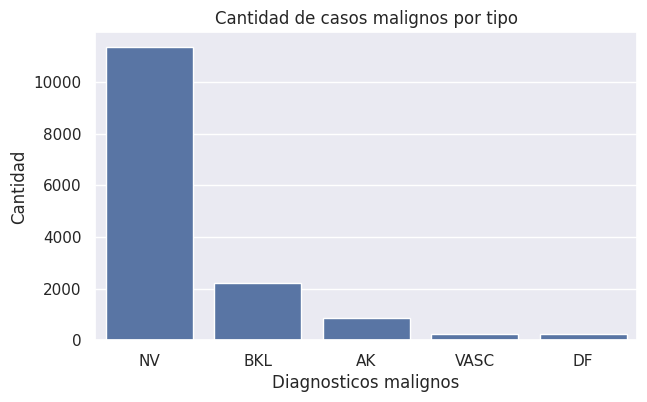

In [ ]:
df_benign = df_ISIC[df_ISIC['benign_malignant'] == 'benign']
order = df_benign.groupby('diagnosis').size().sort_values(ascending=False).index

plt.figure(figsize=(7, 4))
sns.countplot(data=df_benign, x='diagnosis', hue='benign_malignant', order=order)
plt.title('Cantidad de casos malignos por tipo')
plt.xlabel('Diagnosticos malignos')
plt.ylabel('')
plt.xticks(rotation=0)
plt.ylabel('Cantidad')
plt.legend().set_visible(False)
plt.show()


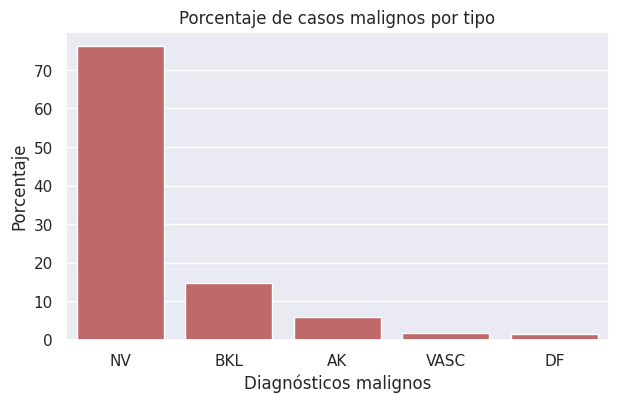

In [ ]:
# Seleccionar solo los casos malignos
df_benign = df_ISIC[df_ISIC['benign_malignant'] == 'benign']

# Contar la cantidad de casos malignos por tipo
bening_counts = df_benign['diagnosis'].value_counts()

# Calcular los porcentajes
total_benign_cases = len(df_benign)
benign_percentages = (bening_counts / total_benign_cases) * 100

plt.figure(figsize=(7, 4))
# Utilizar un gráfico de barras para mostrar la cantidad de casos malignos por tipo
sns.barplot(x=benign_percentages.index, y=benign_percentages.values,color="indianred")
plt.title('Porcentaje de casos malignos por tipo')
plt.xlabel('Diagnósticos malignos')
plt.ylabel('Porcentaje')
plt.show()


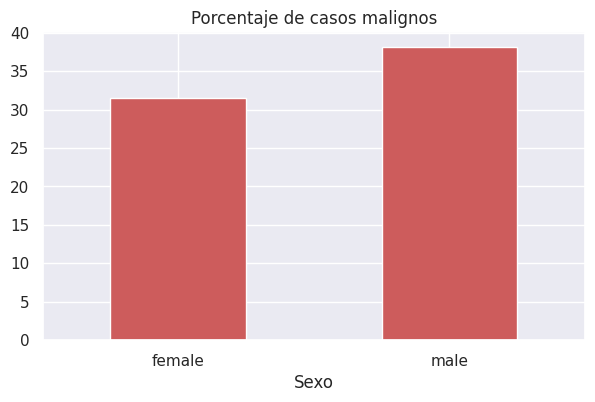

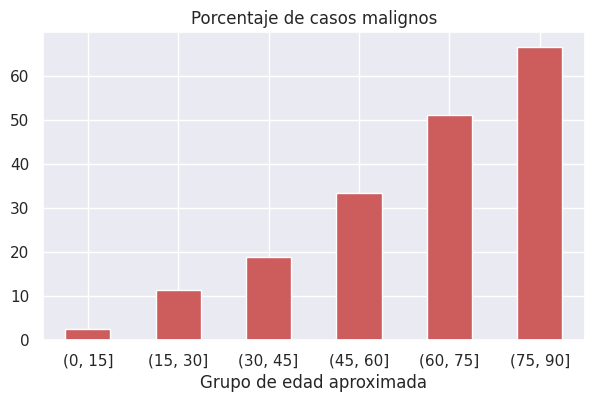

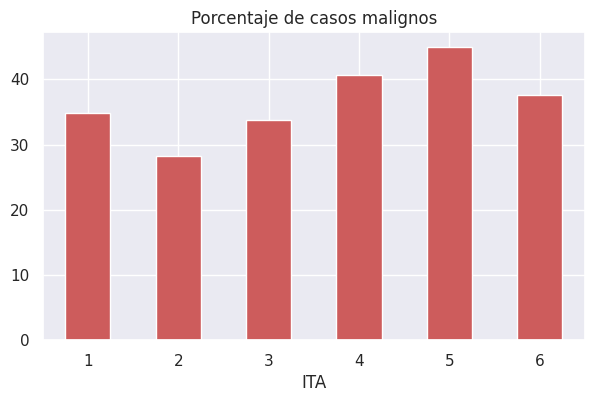

In [ ]:
col_bars = {
    "sex": "Sexo",
    "age_group": "Grupo de edad aproximada",
    "ITA": "ITA",
}
for key, value in col_bars.items():
  crosstb = round(pd.crosstab(df_ISIC[key],df_ISIC["benign_malignant"], normalize='index')*100, 2)
  ax = crosstb['malignant'].plot(title="Porcentaje de casos malignos", kind="bar", color="indianred",
                  stacked=False, rot=0, figsize=(7,4))
  ax.set_xlabel(value);
  plt.show();

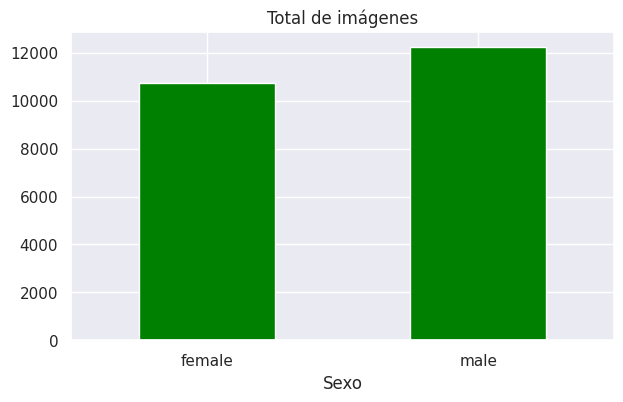

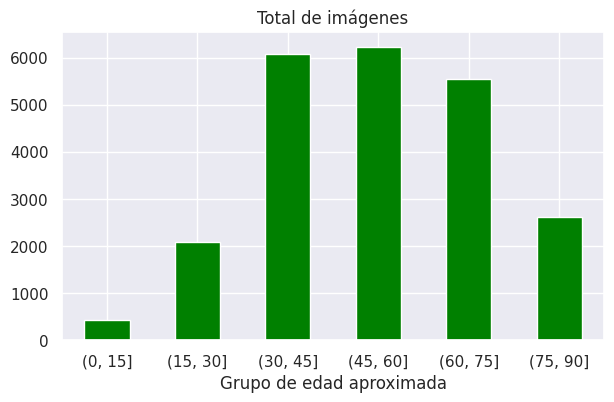

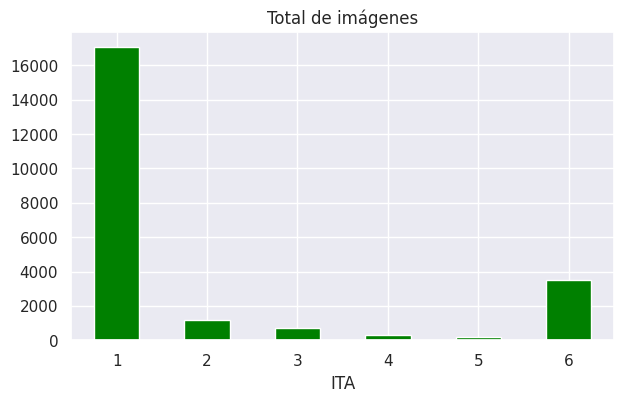

In [ ]:
col_bars = {
    "sex": "Sexo",
    "age_group": "Grupo de edad aproximada",
    "ITA": "ITA",
}

for key, value in col_bars.items():
  ax = df_ISIC[key]\
                             .value_counts().sort_index()\
                             .plot(kind='bar', color="green",rot=0,
                             figsize=(7,4));
  ax.set_xlabel(value);
  ax.set_title("Total de imágenes");
  plt.show();

# **Almacenamiento de los datos transformados**

In [ ]:
# Guardo el df_ISIC con todos los cambios realizados
df_ISIC.to_csv('/content/gdrive/MyDrive/df_ISIC_MOD.csv', index=False)

In [ ]:
# Se carga y se muestra el nuevo dataset creado
df_ISIC_MOD= pd.read_csv('/content/gdrive/MyDrive/df_ISIC_MOD.csv')
df_ISIC_MOD

,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,age_group,benign_malignant,ITA
0,ISIC_0000000,female,55.0,anterior torso,NV,"(45, 60]",benign,6.0
1,ISIC_0000001,female,30.0,anterior torso,NV,"(15, 30]",benign,6.0
2,ISIC_0000002,female,60.0,upper extremity,MEL,"(45, 60]",malignant,6.0
3,ISIC_0000003,male,30.0,upper extremity,NV,"(15, 30]",benign,1.0
4,ISIC_0000004,male,80.0,posterior torso,MEL,"(75, 90]",malignant,1.0
...,...,...,...,...,...,...,...,...
22975,ISIC_0073247,female,85.0,head/neck,BCC,"(75, 90]",malignant,1.0
22976,ISIC_0073248,male,65.0,anterior torso,BKL,"(60, 75]",benign,6.0
22977,ISIC_0073249,male,70.0,lower extremity,MEL,"(60, 75]",malignant,1.0
22978,ISIC_0073251,female,55.0,palms/soles,NV,"(45, 60]",benign,3.0
